cross-referenced.csv comes from combining [pullover data](https://data.cityofnewyork.us/Public-Safety/NYPD-Vehicle-Stop-Reports/hn9i-dwpr/about_data) with the [census data](https://www.nyc.gov/assets/planning/download/office/planning-level/nyc-population/census2020/nyc_detailed-race-and-ethnicity-data_2020_core-geographies.xlsx). We did that using postgis. It is included in the repo but you first need to decompress it using zstd.

In [93]:
import pandas as pd
df=pd.read_csv('cross-referenced.csv')  
df.head(5)

,EVNT_KEY,OCCUR_DT,OCCUR_TM,PRECINCT,VEH_SEIZED_FLG,VEH_SEARCHED_FLG,VEH_SEARCH_CONSENT_FLG,VEH_CHECKPOINT_FLG,FORCE_USED_FLG,ARREST_MADE_FLG,...,RACE_DESC,geography,bct2020,hispanic,white,black,am_indian,asian,hawaiian,other
0,261181977,2023-01-01,02:25:00,18,False,False,NaN,False,False,False,...,HISPANIC,0101000020E61000000FB05E5EA37F52C0A4DE9555BF62...,1013502.0,1430.0,2722.0,595.0,0.0,1452.0,0.0,0.0
1,261182032,2023-01-01,01:45:00,69,False,False,NaN,False,False,False,...,BLACK,0101000020E6100000B51B5CBE5E7A52C07CDF6C31C751...,3095800.0,28.0,0.0,3178.0,0.0,0.0,0.0,0.0
2,261182046,2023-01-01,01:45:00,75,False,False,NaN,False,False,False,...,HISPANIC,0101000020E6100000E8137992747752C04FB3BC829F55...,3121400.0,1630.0,215.0,2363.0,0.0,0.0,0.0,0.0
3,261182058,2023-01-01,01:49:00,88,False,False,NaN,False,False,False,...,BLACK,0101000020E6100000D617AEB3867D52C0CF35E56D1957...,3020100.0,201.0,1998.0,1010.0,0.0,202.0,0.0,0.0
4,261191043,2023-01-01,08:40:00,7,False,False,NaN,False,False,False,...,ASIAN / PACIFIC ISLANDER,0101000020E61000004FFACE71267F52C09A332E5EA45B...,1001402.0,885.0,1071.0,342.0,0.0,915.0,0.0,0.0


In [94]:

df['VEH_CATEGORY'] = df['VEH_CATEGORY'].astype('category')
df['RACE_DESC'] = df['RACE_DESC'].astype('category')
df['SEX_CD'] = df['SEX_CD'].map({'F': 0, 'M': 1})

df["VEH_CATEGORY"] = df["VEH_CATEGORY"].cat.codes
df["RACE_DESC"] = df["RACE_DESC"].cat.codes

df['OCCUR_TM'] = pd.to_datetime(df['OCCUR_TM'], format='%H:%M:%S')
df['OCCUR_TM'] = df['OCCUR_TM'].dt.hour * 3600 + df['OCCUR_TM'].dt.minute * 60 + df['OCCUR_TM'].dt.second

reference_date = pd.Timestamp('1970-01-01')
df['OCCUR_DT'] = (pd.to_datetime(df['OCCUR_DT'], format='%Y-%m-%d') - reference_date).dt.days

df['RPTED_AGE'] = df['RPTED_AGE'].astype('int')

df = df.dropna(subset=['bct2020'])

df = df.drop('VEH_SEARCH_CONSENT_FLG', axis=1)

df['bct2020'] = df['bct2020'].astype(int)

df['hispanic'] = df['hispanic'].astype('int')
df['white'] = df['white'].astype('int')
df['black'] = df['black'].astype('int')
df['am_indian'] = df['am_indian'].astype('int')
df['asian'] = df['asian'].astype('int')
df['hawaiian'] = df['hawaiian'].astype('int')
df['other'] = df['other'].astype('int')


In [95]:
df.head(5)

,EVNT_KEY,OCCUR_DT,OCCUR_TM,PRECINCT,VEH_SEIZED_FLG,VEH_SEARCHED_FLG,VEH_CHECKPOINT_FLG,FORCE_USED_FLG,ARREST_MADE_FLG,SUMMON_ISSUED_FLG,...,RACE_DESC,geography,bct2020,hispanic,white,black,am_indian,asian,hawaiian,other
0,261181977,19358,8700,18,False,False,False,False,False,False,...,3,0101000020E61000000FB05E5EA37F52C0A4DE9555BF62...,1013502,1430,2722,595,0,1452,0,0
1,261182032,19358,6300,69,False,False,False,False,False,True,...,2,0101000020E6100000B51B5CBE5E7A52C07CDF6C31C751...,3095800,28,0,3178,0,0,0,0
2,261182046,19358,6300,75,False,False,False,False,False,False,...,3,0101000020E6100000E8137992747752C04FB3BC829F55...,3121400,1630,215,2363,0,0,0,0
3,261182058,19358,6540,88,False,False,False,False,False,True,...,2,0101000020E6100000D617AEB3867D52C0CF35E56D1957...,3020100,201,1998,1010,0,202,0,0
4,261191043,19358,31200,7,False,False,False,False,False,False,...,1,0101000020E61000004FFACE71267F52C09A332E5EA45B...,1001402,885,1071,342,0,915,0,0


In [96]:
df["VEH_SEARCHED_FLG"].value_counts()

VEH_SEARCHED_FLG
False    799727
True      21161
Name: count, dtype: int64

# inbalanced, smote was utilised for oversampling

Classification Report After Applying SMOTE:
              precision    recall  f1-score   support

       False       0.97      0.90      0.93    159707
        True       0.90      0.97      0.94    160184

    accuracy                           0.93    319891
   macro avg       0.94      0.93      0.93    319891
weighted avg       0.94      0.93      0.93    319891

AUC-ROC Score: 0.98


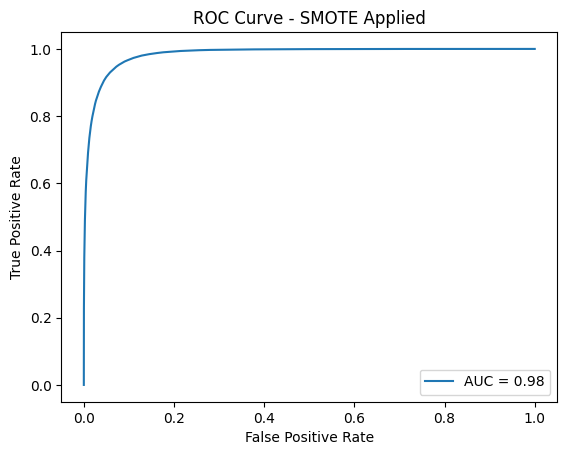

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

df = df.dropna()

race_columns = ['hispanic', 'white', 'black', 'am_indian', 'asian', 'hawaiian', 'other']
scaler = StandardScaler()
df[race_columns] = scaler.fit_transform(df[race_columns])


X = df[["OCCUR_DT","OCCUR_TM", "VEH_CATEGORY", "RPTED_AGE", "SEX_CD", "RACE_DESC", "bct2020"]]
y = df['VEH_SEARCHED_FLG']  

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train, y_train)

y_pred_smote = clf_smote.predict(X_test)

print("Classification Report After Applying SMOTE:")
print(classification_report(y_test, y_pred_smote))

y_proba_smote = clf_smote.predict_proba(X_test)[:, 1]  
roc_auc = roc_auc_score(y_test, y_proba_smote)
print(f"AUC-ROC Score: {roc_auc:.2f}")
fpr, tpr, thresholds = roc_curve(y_test, y_proba_smote)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SMOTE Applied')
plt.legend(loc="lower right")
plt.show()


In [98]:
print(clf_smote.feature_importances_)
print(clf_smote.feature_names_in_)


[0.12876747 0.27769683 0.02160126 0.14281271 0.01447815 0.17187459
 0.24276899]
['OCCUR_DT' 'OCCUR_TM' 'VEH_CATEGORY' 'RPTED_AGE' 'SEX_CD' 'RACE_DESC'
 'bct2020']


# model needed to be scaled down 

In [99]:
df.apply(lambda x: x.unique())

EVNT_KEY              [261181977, 261182032, 261182046, 261182058, 2...
OCCUR_DT              [19358, 19359, 19360, 19361, 19362, 19363, 193...
OCCUR_TM              [8700, 6300, 6540, 31200, 15000, 1800, 16800, ...
PRECINCT              [18, 69, 75, 88, 7, 23, 45, 62, 67, 70, 71, 79...
VEH_SEIZED_FLG                                            [False, True]
VEH_SEARCHED_FLG                                          [False, True]
VEH_CHECKPOINT_FLG                                        [False, True]
FORCE_USED_FLG                                            [False, True]
ARREST_MADE_FLG                                           [False, True]
SUMMON_ISSUED_FLG                                         [False, True]
VEH_CATEGORY                                         [1, 0, 4, 2, 3, 5]
RPTED_AGE             [58, 17, 34, 26, 49, 56, 32, 45, 33, 29, 46, 5...
SEX_CD                                                           [0, 1]
RACE_DESC                                            [3, 2, 1, 5

Classification Report After Applying SMOTE:
              precision    recall  f1-score   support

       False       0.97      0.90      0.93    159707
        True       0.91      0.97      0.94    160184

    accuracy                           0.93    319891
   macro avg       0.94      0.93      0.93    319891
weighted avg       0.94      0.93      0.93    319891

AUC-ROC Score: 0.99


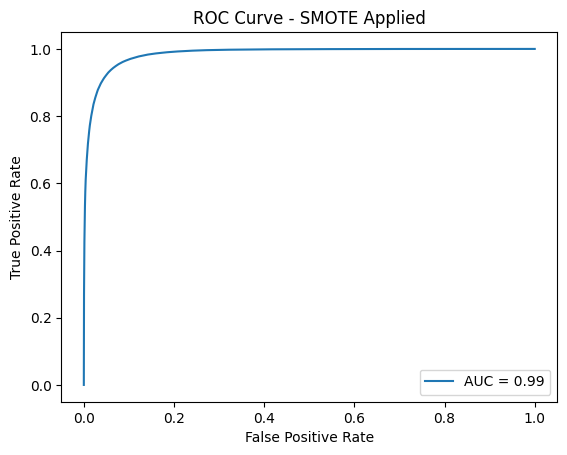

Model saved as random_forest_model.joblib with compression.


In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import joblib

df = df.dropna()

race_columns = ['hispanic', 'white', 'black', 'am_indian', 'asian', 'hawaiian', 'other']
scaler = StandardScaler()
df[race_columns] = scaler.fit_transform(df[race_columns])

le = LabelEncoder()
df['bct2020'] = le.fit_transform(df['bct2020'])
X = df[["OCCUR_DT", "OCCUR_TM", "VEH_CATEGORY", "RPTED_AGE", "SEX_CD", "RACE_DESC", "bct2020"]]
y = df['VEH_SEARCHED_FLG']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train, y_train)

y_pred_smote = clf_smote.predict(X_test)

print("Classification Report After Applying SMOTE:")
print(classification_report(y_test, y_pred_smote))
y_proba_smote = clf_smote.predict_proba(X_test)[:, 1]  # Predict probabilities for AUC-ROC
roc_auc = roc_auc_score(y_test, y_proba_smote)
print(f"AUC-ROC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_smote)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SMOTE Applied')
plt.legend(loc="lower right")
plt.show()

model_filename = "random_forest_model.joblib"
joblib.dump(clf_smote, model_filename, compress=3)
print(f"Model saved as {model_filename} with compression.")


# joblib model was tested, however, when transferred and run on the server model reached 2gb size again

Classification Report After Applying SMOTE on Sampled Data:
              precision    recall  f1-score   support

       False       0.92      0.80      0.86     48042
        True       0.82      0.93      0.87     47952

    accuracy                           0.86     95994
   macro avg       0.87      0.86      0.86     95994
weighted avg       0.87      0.86      0.86     95994

AUC-ROC Score: 0.93


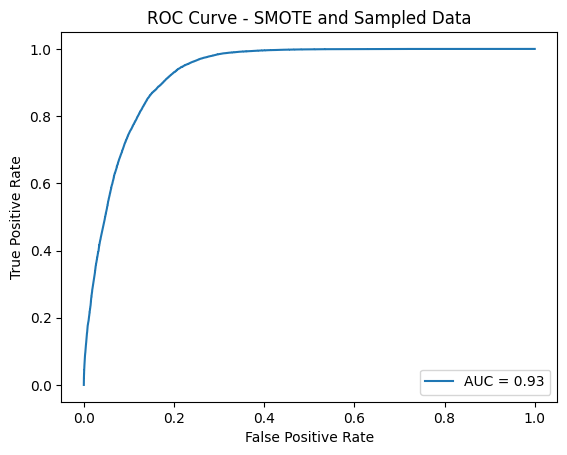

Model saved as final-model-for-server.joblib with compression.


In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import joblib

df_sampled = df.sample(frac=0.3, random_state=42)  
df_sampled = df_sampled.dropna()

race_columns = ['hispanic', 'white', 'black', 'am_indian', 'asian', 'hawaiian', 'other']
scaler = StandardScaler()
df_sampled[race_columns] = scaler.fit_transform(df_sampled[race_columns])

X = df_sampled[["OCCUR_TM", "VEH_CATEGORY", "RPTED_AGE", "SEX_CD", "RACE_DESC", "bct2020"]]
y = df_sampled['VEH_SEARCHED_FLG']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf_smote_sampled = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42)  
clf_smote_sampled.fit(X_train, y_train)

y_pred_smote = clf_smote_sampled.predict(X_test)
print("Classification Report After Applying SMOTE on Sampled Data:")
print(classification_report(y_test, y_pred_smote))

y_proba_smote = clf_smote_sampled.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_smote)
print(f"AUC-ROC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_smote)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SMOTE and Sampled Data')
plt.legend(loc="lower right")
plt.show()
model_filename = "final-model-for-server.joblib"
joblib.dump(clf_smote_sampled, model_filename, compress=3)
print(f"Model saved as {model_filename} with compression.")
